# Deep learning for computer vision


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

# Main task
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

In [7]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print X_train.shape,y_train.shape

(40000, 3, 32, 32) (40000,)


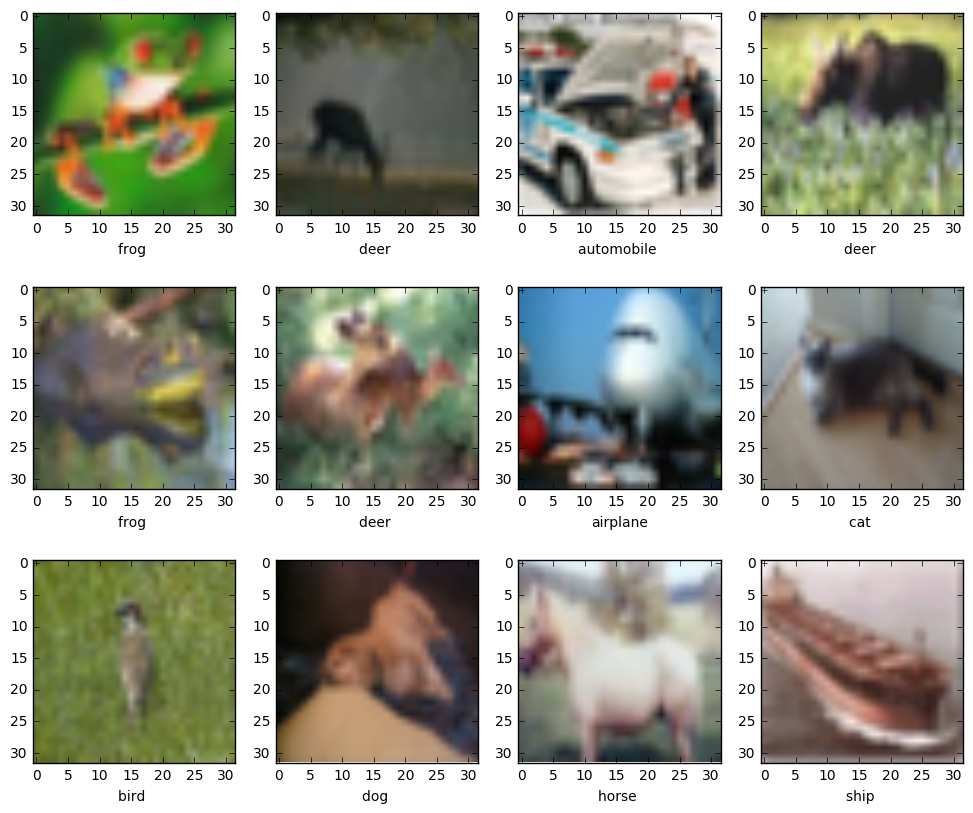

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano


In [3]:
import lasagne
import theano
import theano.tensor as T

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary")
input_shape = [None,3,32,32]

target_y = T.vector("target Y integer",dtype='int32')

Using gpu device 0: GeForce GT 640 (CNMeM is enabled with initial size: 30.0% of memory, cuDNN 5103)
/home/hpish/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Defining network architecture

In [13]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

conv1 = lasagne.layers.Conv2DLayer(input_layer,
            num_filters=10,
            filter_size=(3, 3),nonlinearity= lasagne.nonlinearities.rectify)

batchnorm = lasagne.layers.BatchNormLayer(conv1)

pool1 = lasagne.layers.Pool2DLayer(batchnorm,pool_size=(3, 3))

flatten = lasagne.layers.FlattenLayer(pool1)


dense_1 = lasagne.layers.DenseLayer(
            flatten,
            num_units=100,nonlinearity = lasagne.nonlinearities.rectify)

dropout = lasagne.layers.DropoutLayer(dense_1,p=0.1)

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
dense_output = lasagne.layers.DenseLayer(dropout,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')


In [14]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [15]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)
print all_weights

[W, b, beta, gamma, W, b, output.W, output.b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [16]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy (WITH dropout)
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adam(loss, all_weights,learning_rate=0.01)

In [17]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)


In [18]:
#deterministic prediciton (without dropout)
y_predicted_det = lasagne.layers.get_output(dense_output,deterministic=True)

#prediction accuracy (without dropout)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det,target_y).mean()

#function that just computes accuracy without dropout/noize -- for evaluation purposes
accuracy_fun = theano.function([input_X,target_y],accuracy_det)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [1]:
def shuffle(a, b):
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [2]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# X - a tensor of images with shape (many, 3, 32, 32), e.g. X_train
# y - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

#What do need to implement
# 1) Shuffle data
# - Gotta shuffle X and y the same way not to break the correspondence between X_i and y_i
# 3) Split data into minibatches of batch_size
# - If data size is not a multiple of batch_size, make one last batch smaller.
# 4) return a list (or an iterator) of pairs
# - (подгруппа картинок, ответы из y на эту подгруппу)
def iterate_minibatches(X, y, batchsize):
    batchnum = len(X)//batchsize
    X_shuff, y_shuff = shuffle(X, y)
    Batchlist = []
    for i in range(batchnum):
        X_batch = X_shuff[i*batchsize:(i+1)*batchsize]
        y_batch = y_shuff[i*batchsize:(i+1)*batchsize]
        Batchlist.append((X_batch,y_batch))
    return Batchlist
    
        
        
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
# You feel lost and wish you stayed home tonight?
# Go search for a similar function at
# https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

# Training loop

In [21]:
import time

num_epochs = 100 #amount of passes through the data
            
batch_size = 50 #number of samples processed at each function call

patience = 7
patience_increase = 7  
improvement_threshold = 0.995
best_validation_acc = -np.inf
epoch = 0

while epoch < patience:
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1
        this_validation_acc = val_acc / val_batches
    
    if this_validation_acc > best_validation_acc:
                #improve patience if loss improvement is good enough
        if (this_validation_acc*improvement_threshold > best_validation_acc ):
            patience = max(patience, epoch+patience_increase)
            best_validation_acc = this_validation_acc
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    epoch+=1

Epoch 1 of 100 took 6.821s
  training loss (in-iteration):		1.740481
  train accuracy:		38.26 %
  validation accuracy:		49.91 %
Epoch 2 of 100 took 6.711s
  training loss (in-iteration):		1.391674
  train accuracy:		50.19 %
  validation accuracy:		54.01 %
Epoch 3 of 100 took 6.705s
  training loss (in-iteration):		1.293573
  train accuracy:		54.24 %
  validation accuracy:		55.62 %
Epoch 4 of 100 took 6.705s
  training loss (in-iteration):		1.228971
  train accuracy:		56.87 %
  validation accuracy:		54.27 %
Epoch 5 of 100 took 6.707s
  training loss (in-iteration):		1.168761
  train accuracy:		59.06 %
  validation accuracy:		56.43 %
Epoch 6 of 100 took 6.700s
  training loss (in-iteration):		1.121025
  train accuracy:		60.80 %
  validation accuracy:		57.85 %
Epoch 7 of 100 took 6.808s
  training loss (in-iteration):		1.074852
  train accuracy:		62.58 %
  validation accuracy:		58.24 %
Epoch 8 of 100 took 6.763s
  training loss (in-iteration):		1.026586
  train accuracy:		64.54 %
  valida

In [22]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 95:
    print "Double-check, than consider applying for NIPS'17. SRSly."
elif test_acc / test_batches * 100 > 90:
    print "U'r freakin' amazin'!"
elif test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 110lvl Warlock!"
elif test_acc / test_batches * 100 > 70:
    print "Achievement unlocked: 80lvl Warlock!"
elif test_acc / test_batches * 100 > 50:
    print "Achievement unlocked: 60lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		58.85 %
Achievement unlocked: 60lvl Warlock!


# First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and ReLU activation
* 3x3 pooling (or set previous convolution stride to 3)
* Dense layer with 100-neurons and ReLU activation
* 10% dropout
* Output dense layer.

Train it with Adam optimizer with default params.


# Second step

* Add batch_norm (with default params) between convolution and pooling

Re-train the network with the same optimizer


# Quest For A Better Network

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)
    
## Bonus points

Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example "A super-small/fast NN that gets 80%" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                        num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc

 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
   
   
   
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way

In [9]:
import numpy as np
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print X_train.shape,y_train.shape

(40000, 3, 32, 32) (40000,)


In [10]:
import PIL
import Image
X_flipped = np.empty(X_train.shape)
for i in range(len(X_train)):
    im = Image.fromarray(np.rollaxis(np.uint8(X_train[i]*255), 0,3))
    pic = np.rollaxis(np.array(im.transpose(PIL.Image.FLIP_LEFT_RIGHT))/255.,2,0)
    X_flipped[i] = pic

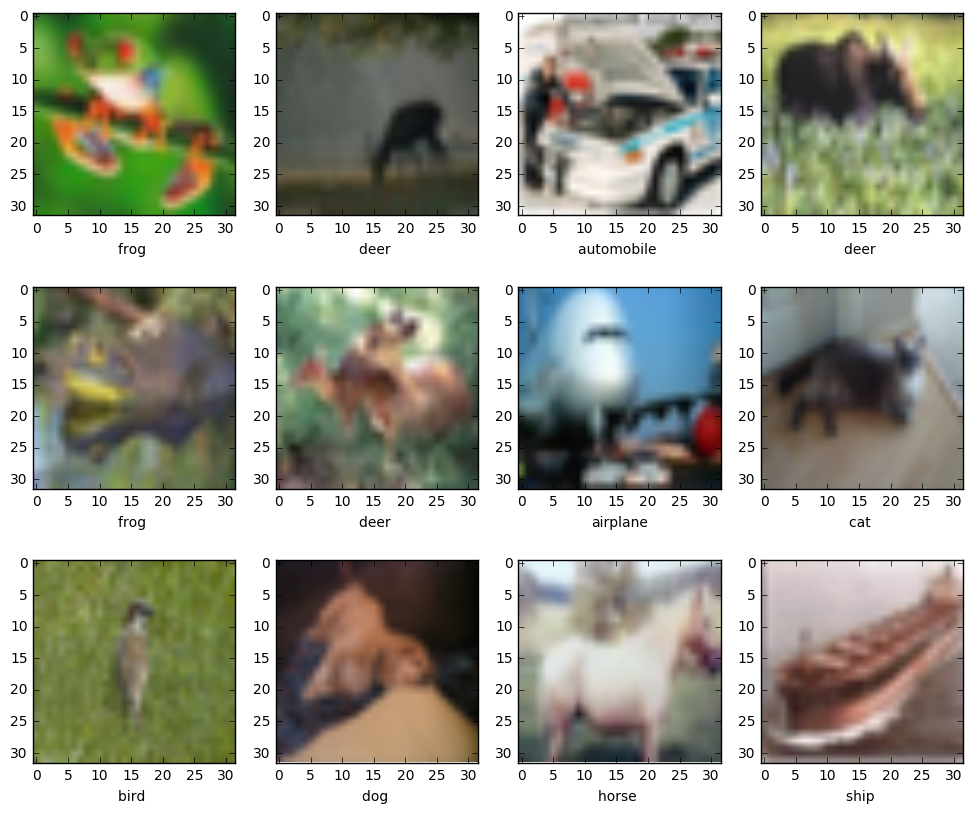

In [11]:
plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_flipped[i],[1,2,0]))

In [12]:
X_aug = np.concatenate((X_train, X_flipped), axis=0)
y_aug = np.concatenate((y_train,y_train))
print X_aug.shape
print y_aug.shape

(80000, 3, 32, 32)
(80000,)


In [13]:
del X_train,y_train

In [14]:
import lasagne
import theano
import theano.tensor as T

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,3,32,32]

target_y = T.vector("target Y integer",dtype='int32')

Using gpu device 0: GeForce GT 640 (CNMeM is enabled with initial size: 30.0% of memory, cuDNN 5103)
/home/hpish/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [15]:
#Input layer (auxilary)

X_batch = T.ftensor4(name='images')

input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

conv1 = lasagne.layers.Conv2DLayer(input_layer,
            num_filters=32,
            filter_size=(5, 5),nonlinearity=lasagne.nonlinearities.rectify)

Batchnorm1 = lasagne.layers.BatchNormLayer(conv1)

pool1 = lasagne.layers.Pool2DLayer(Batchnorm1,pool_size=(2, 2))

conv2 = lasagne.layers.Conv2DLayer(pool1,
            num_filters=64,
            filter_size=(3, 3),nonlinearity=lasagne.nonlinearities.rectify)

Batchnorm2 = lasagne.layers.BatchNormLayer(conv2)

pool2 = lasagne.layers.Pool2DLayer(Batchnorm2,pool_size=(2, 2))

conv3 = lasagne.layers.Conv2DLayer(pool2,
            num_filters=64,
            filter_size=(3, 3),nonlinearity=lasagne.nonlinearities.rectify)

Batchnorm3 = lasagne.layers.BatchNormLayer(conv3)

flatten = lasagne.layers.FlattenLayer(Batchnorm3)


dense_1 = lasagne.layers.DenseLayer(flatten,num_units=64,
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   name = "hidden_dense_layer")

dropout_1 = lasagne.layers.DropoutLayer(dense_1,p=0.1)

dense_2 = lasagne.layers.DenseLayer(dropout_1,num_units=25,
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   name = "hidden_dense_layer")

dropout_2 = lasagne.layers.DropoutLayer(dense_1,p=0.1)

dense_output = lasagne.layers.DenseLayer(dropout_2,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')

In [16]:
# Network predictions (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [17]:
#All weights (shared-varaibles)
# "trainable" flag means not to return auxilary params like batch mean (for batch normalization)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)
print all_weights

[W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


In [18]:
from lasagne.regularization import regularize_layer_params_weighted, l2, l1
from lasagne.regularization import regularize_layer_params

In [19]:
l2_penalty = regularize_layer_params([dense_1,dense_2,dense_output], l2)

#loss function
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean() + 0.01*l2_penalty

#<optionally add regularization>

#accuracy with dropout/noize
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#weight updates
updates = lasagne.updates.adam(loss, all_weights,learning_rate=0.01)

In [20]:
#A function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates = updates,allow_input_downcast=True)


In [21]:
#deterministic prediciton (without dropout)
y_predicted_det = lasagne.layers.get_output(dense_output)

#prediction accuracy (without dropout)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det,target_y).mean()

#function that just computes accuracy without dropout/noize -- for evaluation purposes
accuracy_fun = theano.function([input_X,target_y],accuracy_det)

In [22]:
#итерации обучения

import time

num_epochs = 10 #amount of passes through the data
            
batch_size = 200 #number of samples processed at each function call

patience = 10
patience_increase = 5  
improvement_threshold = 0.995
best_validation_acc = -np.inf
epoch = 0

while epoch < patience:
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_aug, y_aug,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1
        this_validation_acc = val_acc / val_batches
    
    if this_validation_acc > best_validation_acc:
                #improve patience if loss improvement is good enough
        if (this_validation_acc*improvement_threshold > best_validation_acc ):
            patience = max(patience, epoch+patience_increase)
            best_validation_acc = this_validation_acc
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    epoch+=1

Epoch 1 of 10 took 48.377s
  training loss (in-iteration):		2.080347
  train accuracy:		50.17 %
  validation accuracy:		58.47 %
Epoch 2 of 10 took 48.046s
  training loss (in-iteration):		1.823011
  train accuracy:		63.42 %
  validation accuracy:		65.42 %
Epoch 3 of 10 took 47.919s
  training loss (in-iteration):		1.742312
  train accuracy:		68.24 %
  validation accuracy:		69.75 %
Epoch 4 of 10 took 48.491s
  training loss (in-iteration):		1.679745
  train accuracy:		71.29 %
  validation accuracy:		70.19 %
Epoch 5 of 10 took 48.230s
  training loss (in-iteration):		1.653900
  train accuracy:		72.97 %
  validation accuracy:		71.13 %
Epoch 6 of 10 took 48.122s
  training loss (in-iteration):		1.633879
  train accuracy:		74.05 %
  validation accuracy:		73.75 %
Epoch 7 of 10 took 47.989s
  training loss (in-iteration):		1.611175
  train accuracy:		75.14 %
  validation accuracy:		72.77 %
Epoch 8 of 10 took 47.823s
  training loss (in-iteration):		1.596535
  train accuracy:		75.93 %
  valida

In [23]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: 80lvl Warlock!"
else:
    print "We need more magic!"

Final results:
  test accuracy:		77.22 %
We need more magic!


Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `Max`, and here's my story

A long ago in a galaxy far far away, when it was still more than an hour before deadline, i got an idea:

##### I gonna build a neural network, that
Is going to distinguish pictures of 10 different classes.
The base architecture was involving 1 convolution- Maxpooling with Relu nonlinearities and two dense layers with dropout between them. That din't fare too well. 

How could i be so naive?!

##### One day, with no signs of warning,
I decided to build another one.

This time i added several convolution-pooling layers. I decided that 3 layer convolution work best- not too parameter-expensive, and the resulting dimentions are even, which is convenient. The idea is that conv-pool pairs would capture more and more general features on each image.
The general idea was also picked from here: http://torch.ch/blog/2015/07/30/cifar.html.
As is was possible to reach such high accuracy only using small convolutions, and not blowing up parameters, i decided to use similar structure. I managed to reach about 74 with it, then decided to try and increase first convolution size.It manages to learn slightly better features this way.

Also, i added another dense layer with sigmoid activation to model possible nonlinear representations of features learnt in convolution layers.The batch normalisation was added before pooling for regularisation, and dropouts between dense layers to prevent overfitting. Overfitting remaied the main ussue through different iterations of the model.The composition itself is rather standard for convolution network, however it seems too shallow to reach accuracy of 80+%.
However, increasing convolution layers only lead to better initial state and faster overfitting. Any value bigger than 0.1 lead to troubles with learning best weights.Regularisation does help, as compared with and without it, but only slightly. I did not succeed in combatting overfitting totally with dropout and batch normalisation, as increasing dropout values led in turn to lower converging accuracy.

So, i've tried adam, nesterov momentum and rmsprop optimisers. Nesterov has a nice property of being fast to compute and useful with the momentum feature, but it wobbled around opimum.RMSprop and Adam were used instead as a way to approach convergence more smoothely. Adam seemed faster and a bit more stable of the two, so i picked it.
Choosed with with respect to this post. http://sebastianruder.com/optimizing-gradient-descent/index.html#rmsprop



##### Finally, after __  iterations, __ mugs of [tea/coffee]
Final architecture:
5x5 Conv
max pool
3x3 Conv
max pool
3x3 Conv
max pool
2x dense layers(sigmoid nonlinearity) + dropout
output(softmax)

Relu for convolutions, as it is most logical, it does not saturate and benefits from batchnorm.

Also augmented data by flipping left and right. Adding gaussian noize didn't seem like a good idea, given that even small noize destroys the picture. For the same reason zooming and turning seemed risky- in some images class is barely guessable by naked eye, and if we want to learn features that make some sense, it seemed rigth not to decrease picture quality further


Trained via Adam

That, having wasted quite a lot [minutes, hours or days] of my life training, got

* best accuracy on training: 85%
* best accuracy on validation: 78%
* best accuracy on test: 78%


[an optional afterword and mortal curses on assignment authors]